In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import warnings
import pickle
warnings.filterwarnings("ignore")

root_dir = Path.cwd().parent
print(root_dir)

/DATA/Luis/thesis/scanline_classification


# All attributes together: model performance

n_estimators = 200

max_depth = 6

learning_rate = 0.3

In [11]:
testing_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/all_results/testing_cls_results.csv'
validation_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/all_results/validation_cls_results.csv'

testing_results = pd.read_csv(testing_results_path)
validation_results = pd.read_csv(validation_results_path)

# Rename the first columns
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})
testing_results['mode'] = 'testing'
validation_results = validation_results.rename(columns={'Unnamed: 0': 'attribute'})
validation_results['mode'] = 'validation'

# Remove 'accuracy' and 'macro avg' rows
testing_results = testing_results[testing_results['attribute'] != 'accuracy']
testing_results = testing_results[testing_results['attribute'] != 'macro avg']
validation_results = validation_results[validation_results['attribute'] != 'accuracy']
validation_results = validation_results[validation_results['attribute'] != 'macro avg']

# Merge the two dataframes
all_results = pd.concat([testing_results, validation_results])

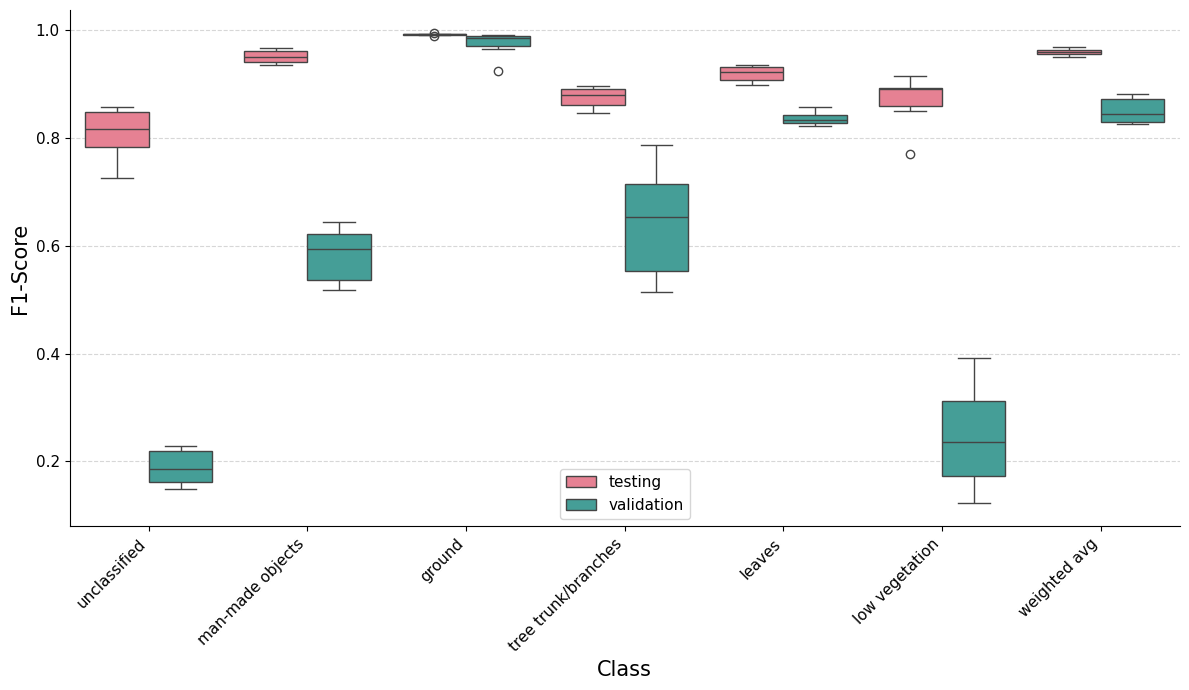

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

box_plot = sns.boxplot(x='attribute', y='f1-score', data=all_results, hue='mode', palette=sns.color_palette("husl", 2), ax=ax1)

# Highlight 'weighted avg' with light grey color
for i, artist in enumerate(box_plot.artists):
    print(i, artist.get_facecolor())
    print(artist)
    
    # This artist contains rectangle for boxplot
    if box_plot.get_xticklabels()[i].get_text() == 'weighted avg':
        print('weighted avg')
        artist.set_facecolor('lightgrey')

ax1.set_xlabel('Class', fontdict={'size': 15})
ax1.set_ylabel('F1-Score', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Ajust legend
ax1.legend(loc='lower center', fontsize=11, title='')

plt.tight_layout()
plt.show()

## Confusion matrices

### Training

In [46]:
cnf_mat_testing_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/confusion_matrices_testing'

In [61]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_testing_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_testing_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [62]:
cnf_mat_testing_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.8339,0.1161,0.0239,0.0069,0.0099,0.0094
man-made objects,0.0113,0.9447,0.0280,0.0107,0.0022,0.0030
ground,0.0001,0.0010,0.9979,0.0001,0.0003,0.0006
tree trunk/branches,0.0022,0.0193,0.0137,0.8850,0.0759,0.0039
leaves,0.0046,0.0016,0.0121,0.0815,0.8978,0.0025
low vegetation,0.0119,0.0256,0.0678,0.0052,0.0009,0.8886


### Validation

In [63]:
cnf_mat_validation_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/confusion_matrices_validation'

In [64]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_validation_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_validation_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [65]:
cnf_mat_validation_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.6547,0.1603,0.0415,0.0389,0.0719,0.0327
man-made objects,0.0847,0.4965,0.0097,0.3955,0.0129,0.0008
ground,0.0052,0.0144,0.9671,0.0009,0.0007,0.0117
tree trunk/branches,0.0270,0.1338,0.0207,0.7185,0.0866,0.0134
leaves,0.0340,0.0077,0.0107,0.1459,0.7914,0.0103
low vegetation,0.3830,0.1170,0.1471,0.0152,0.0171,0.3206


# Feature importance

## Overall result

In [66]:
dir = Path("/DATA/Luis/thesis/scanline_classification/data/data_for_training_final_SM2CT20NM3_v02/classification_training_sample10000/all_results/feature_importance_results_full_res.csv")
df = pd.read_csv(dir)

df['feature_importance'] = -999.0
classes = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
stats = df['statistics'].unique()
filenames = df['filename'].unique()

In [68]:
metric = 'f1-score'

for filename in filenames:
    for stat in stats:
        for cl in classes:
            df_subset = df[(df['filename'] == filename) & (df['statistics'] == stat) & (df['attribute'] == cl)]
            baseline_f1 = df_subset[df_subset['baseline_model'] == 1][metric].values[0]
            feature_importance = baseline_f1 - df_subset[metric]
            df.loc[df_subset.index, 'feature_importance'] = feature_importance
            
df_analysis = df[df['feature_importance'] != -999.0]

In [69]:
order = df_analysis.groupby('drop_col')['feature_importance'].mean().sort_values(ascending=False).index
order_dict = {value: i for i, value in enumerate(order)}
df_analysis['order'] = df_analysis['drop_col'].map(order_dict)
df_analysis = df_analysis.sort_values('order')
df_analysis = df_analysis.drop(columns='order')
df_analysis = df_analysis[df_analysis['drop_col'] != 'none']

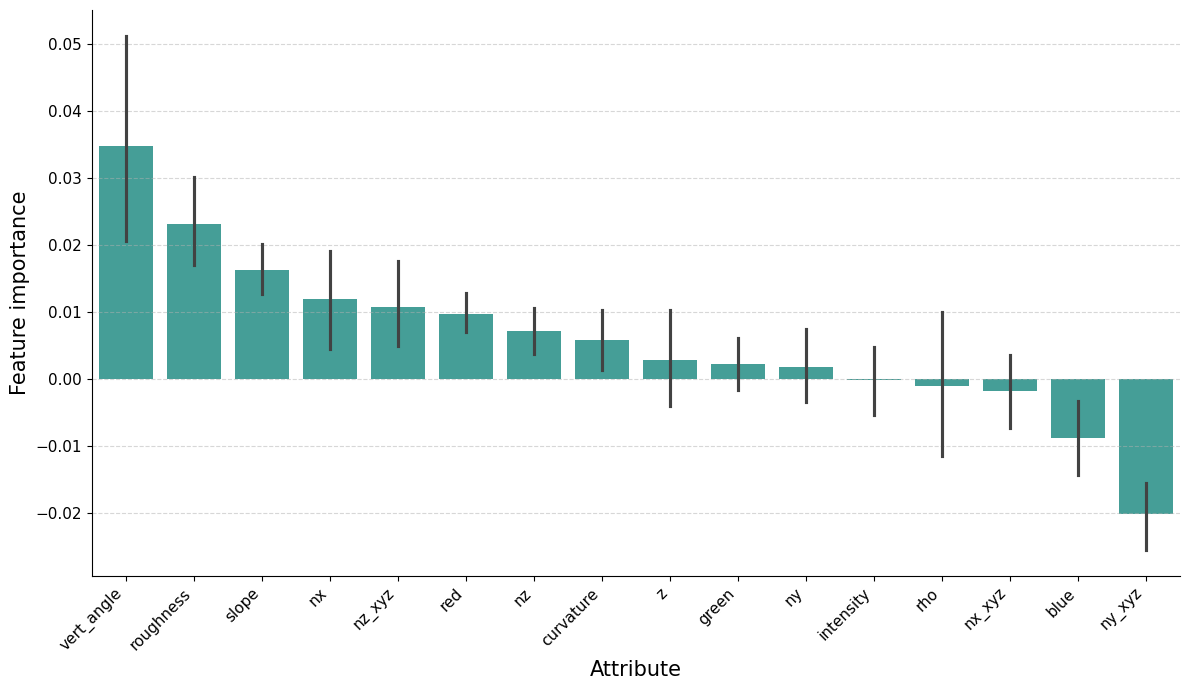

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

sns.barplot(x='drop_col', y='feature_importance', data=df_analysis, color=sns.color_palette("husl", 4)[2], ax=ax1)
ax1.set_xlabel('Attribute', fontdict={'size': 15})
ax1.set_ylabel('Feature importance', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Each class

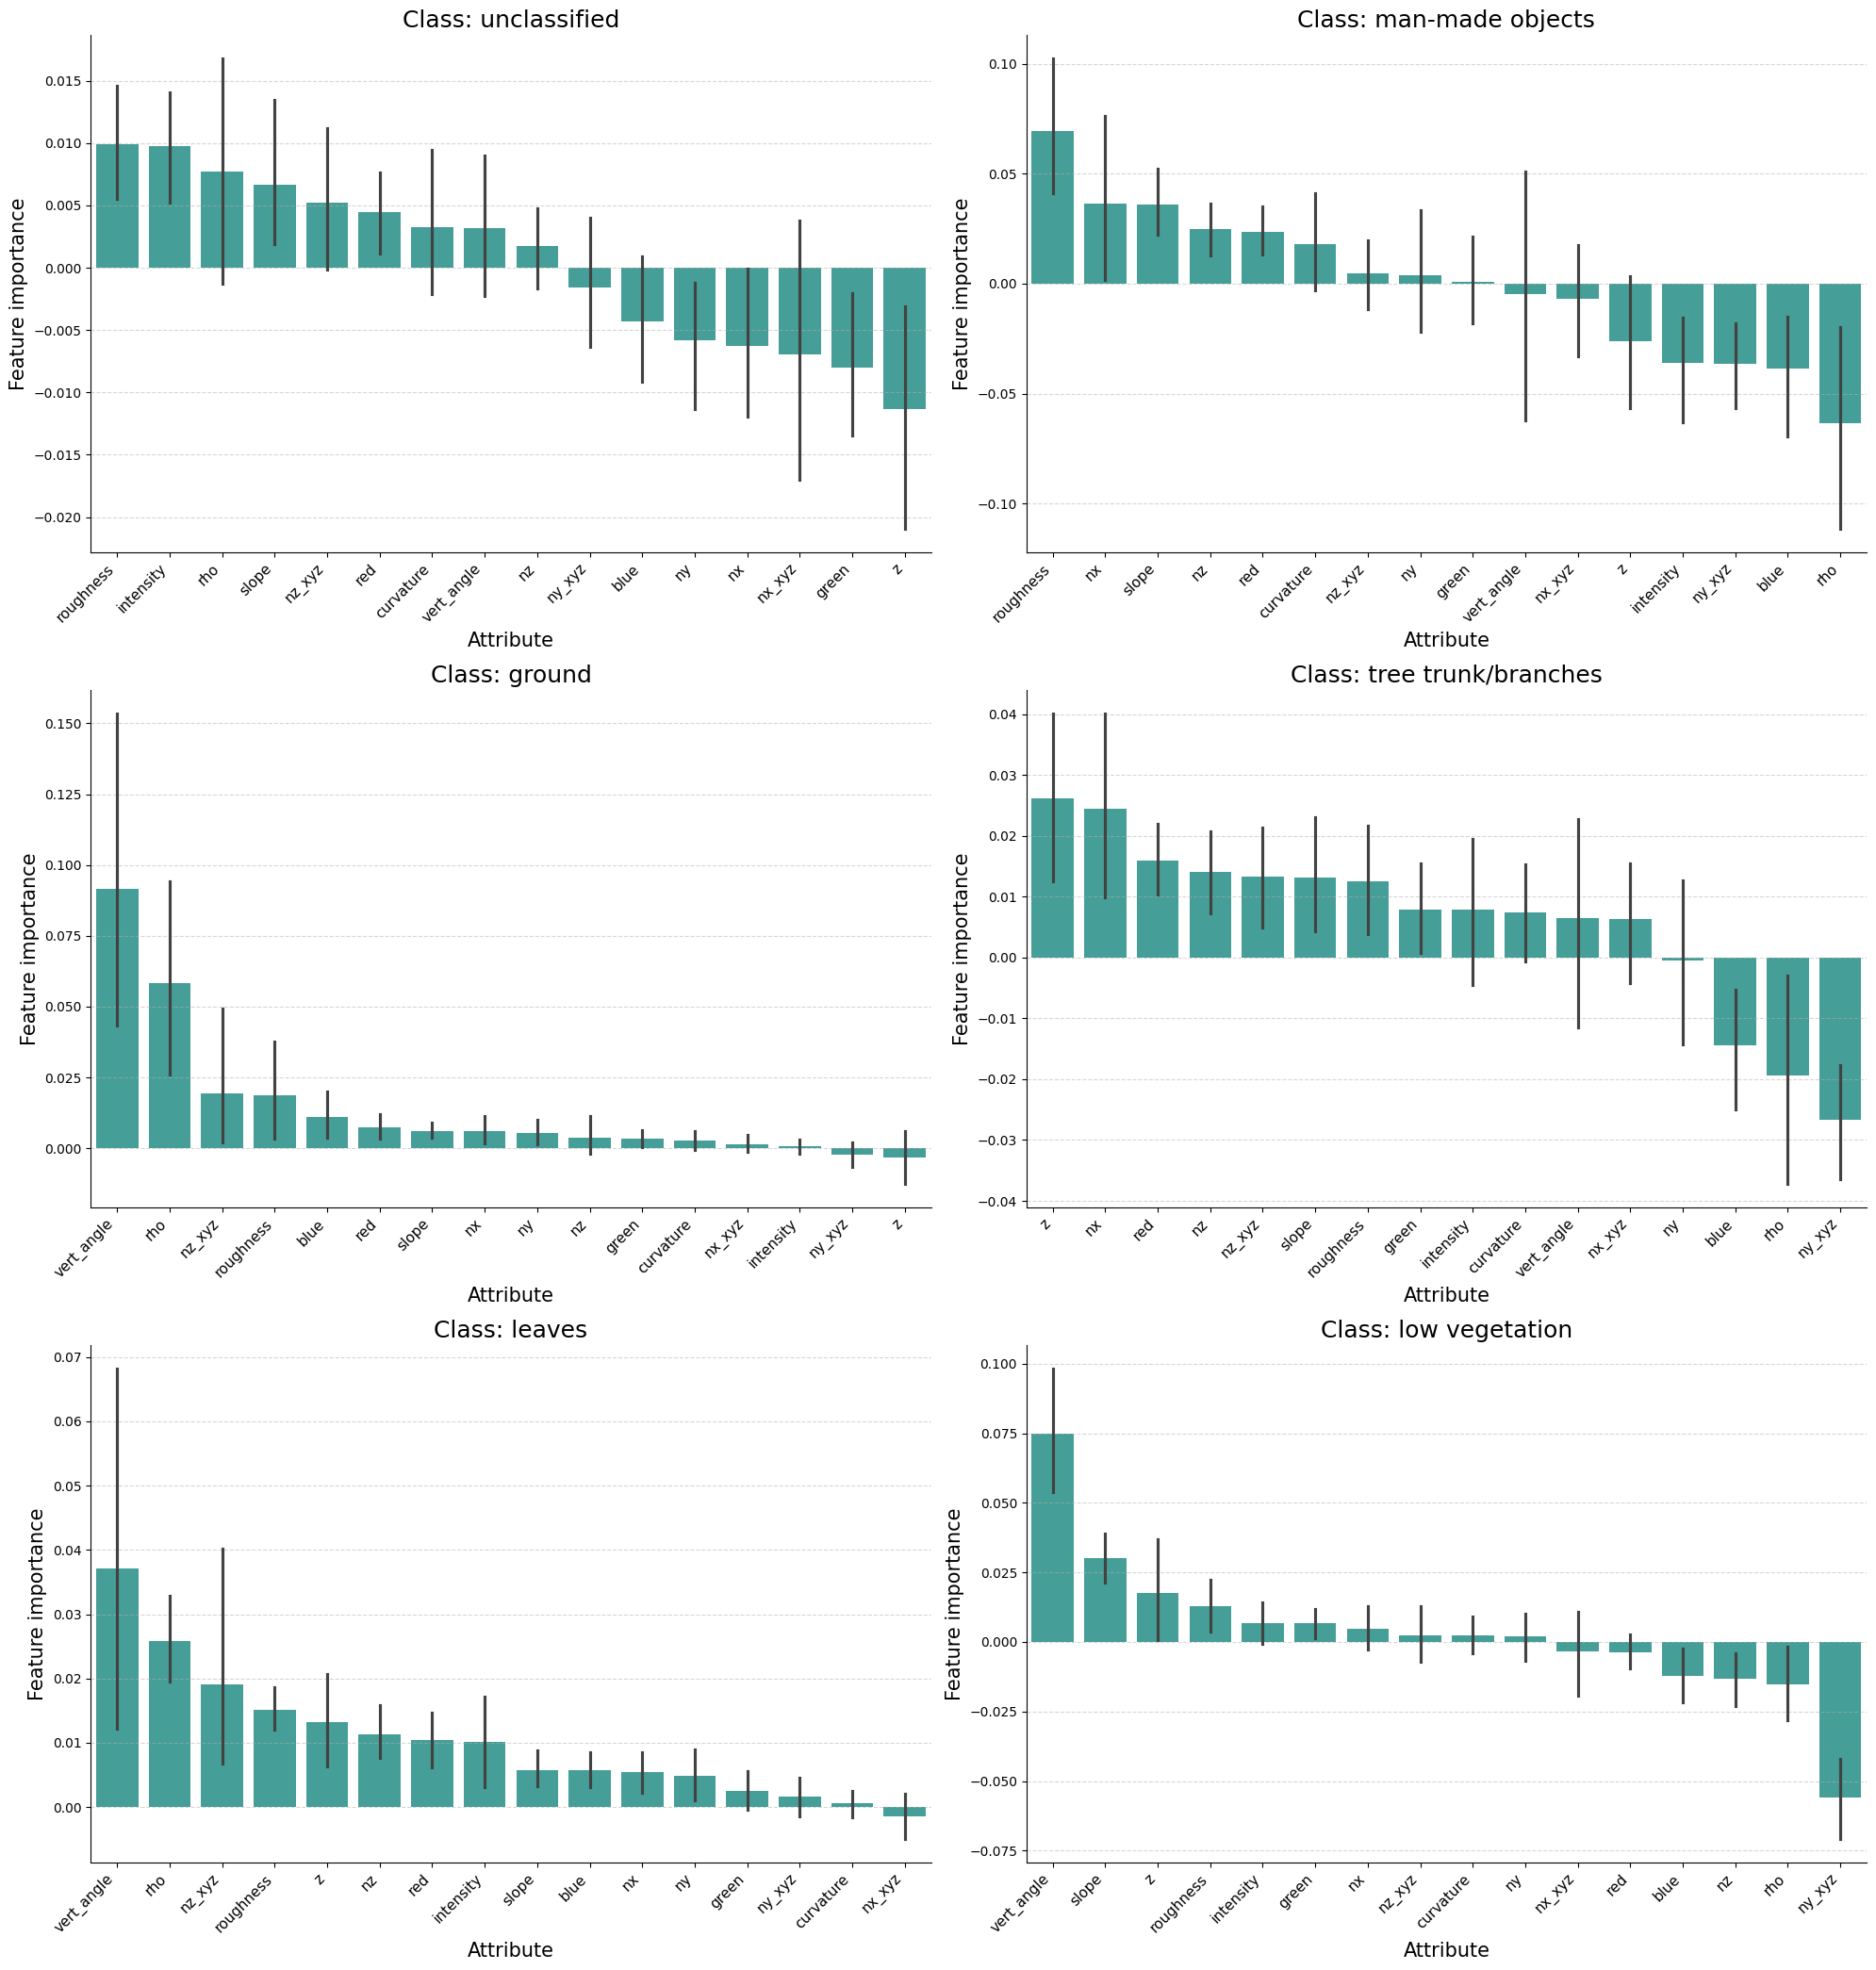

In [71]:
# Get unique statistics
cl = df_analysis['attribute'].unique()

# Calculate number of rows and columns for subplots
n = len(cl)
ncols = 2
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols, 7*nrows))

# Flatten the axes array to easily iterate over it
axs = axs.flatten()

for i, class_name in enumerate(cl):
    # Subset the dataframe for the current statistic
    df_subset = df_analysis[df_analysis['attribute'] == class_name]
    
    order = df_subset.groupby('drop_col')['feature_importance'].mean().sort_values(ascending=False).index
    order_dict = {value: i for i, value in enumerate(order)}
    df_subset['order'] = df_subset['drop_col'].map(order_dict)
    df_subset = df_subset.sort_values('order')
    df_subset = df_subset.drop(columns='order')
    df_subset = df_subset[df_subset['drop_col'] != 'none']
    
    # Create a barplot for the current statistic
    sns.barplot(x='drop_col', y='feature_importance', data=df_subset, color=sns.color_palette("husl", 4)[2], ax=axs[i])
    
    # Set x and y labels
    axs[i].set_xlabel('Attribute', fontdict={'size': 15})
    axs[i].set_ylabel('Feature importance', fontdict={'size': 15})
    
    # Set title for the subplot
    axs[i].set_title(f'Class: {class_name}', fontdict={'size': 18})

    # Remove top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Set the size of the tick labels
    axs[i].tick_params(axis='x', labelsize=11)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

    # Add grid
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove extra subplots
if n < nrows * ncols:
    for ax in axs[n:]:
        fig.delaxes(ax)


plt.tight_layout()
plt.show()

## Feature importance of statistics

In [72]:
dir = Path("/DATA/Luis/thesis/scanline_classification/data/data_for_training_final_SM2CT20NM3_v02/feature_importance_stats/all_results/cls_results_fr.csv")
df = pd.read_csv(dir)

df['feature_importance'] = -999.0
classes = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
stats = df['drop_statistics'].unique()
columns = df['column'].unique()
filenames = df['filename'].unique()

# Rename the first column
df = df.rename(columns={'Unnamed: 0': 'attribute'})


In [74]:
metric = 'f1-score'

for filename in filenames:
    for col in columns:
        for cl in classes:
            df_subset = df[(df['filename'] == filename) & (df['column'] == col) & (df['attribute'] == cl)]
            baseline_f1 = df_subset[df_subset['baseline_model'] == 1][metric].values[0]
            feature_importance = baseline_f1 - df_subset[metric]
            df.loc[df_subset.index, 'feature_importance'] = feature_importance

In [75]:
df_analysis = df[df['feature_importance'] != -999.0]

order = df_analysis.groupby('drop_statistics')['feature_importance'].mean().sort_values(ascending=False).index
order_dict = {value: i for i, value in enumerate(order)}
df_analysis['order'] = df_analysis['drop_statistics'].map(order_dict)
df_analysis = df_analysis.sort_values('order')
df_analysis = df_analysis.drop(columns='order')
df_analysis = df_analysis[df_analysis['drop_statistics'] != 'none']

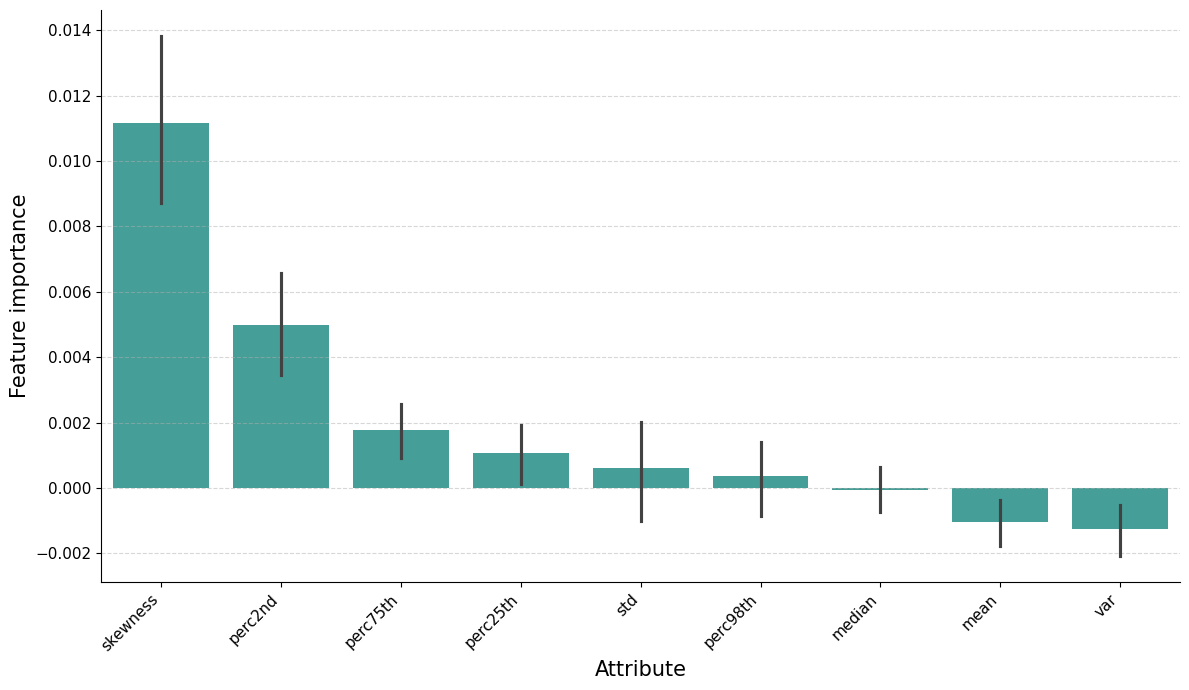

In [76]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

sns.barplot(x='drop_statistics', y='feature_importance', data=df_analysis, color=sns.color_palette("husl", 4)[2], ax=ax1)
ax1.set_xlabel('Attribute', fontdict={'size': 15})
ax1.set_ylabel('Feature importance', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Hyperparameter testing

In [84]:
testing_dir = Path("/DATA/Luis/thesis/scanline_classification/data/final_results/1_hyperparameter_testing/all_results/testing_cls_results.csv")
validation_dir = Path("/DATA/Luis/thesis/scanline_classification/data/final_results/1_hyperparameter_testing/all_results/validation_cls_results.csv")
testing_df = pd.read_csv(testing_dir)
validation_df = pd.read_csv(validation_dir)

# Rename the first column
testing_df = testing_df.rename(columns={testing_df.columns[0]: "attribute"})
validation_df = validation_df.rename(columns={validation_df.columns[0]: "attribute"})

testing_avg = testing_df[testing_df["attribute"] == "weighted avg"]
validation_avg = validation_df[validation_df["attribute"] == "weighted avg"]

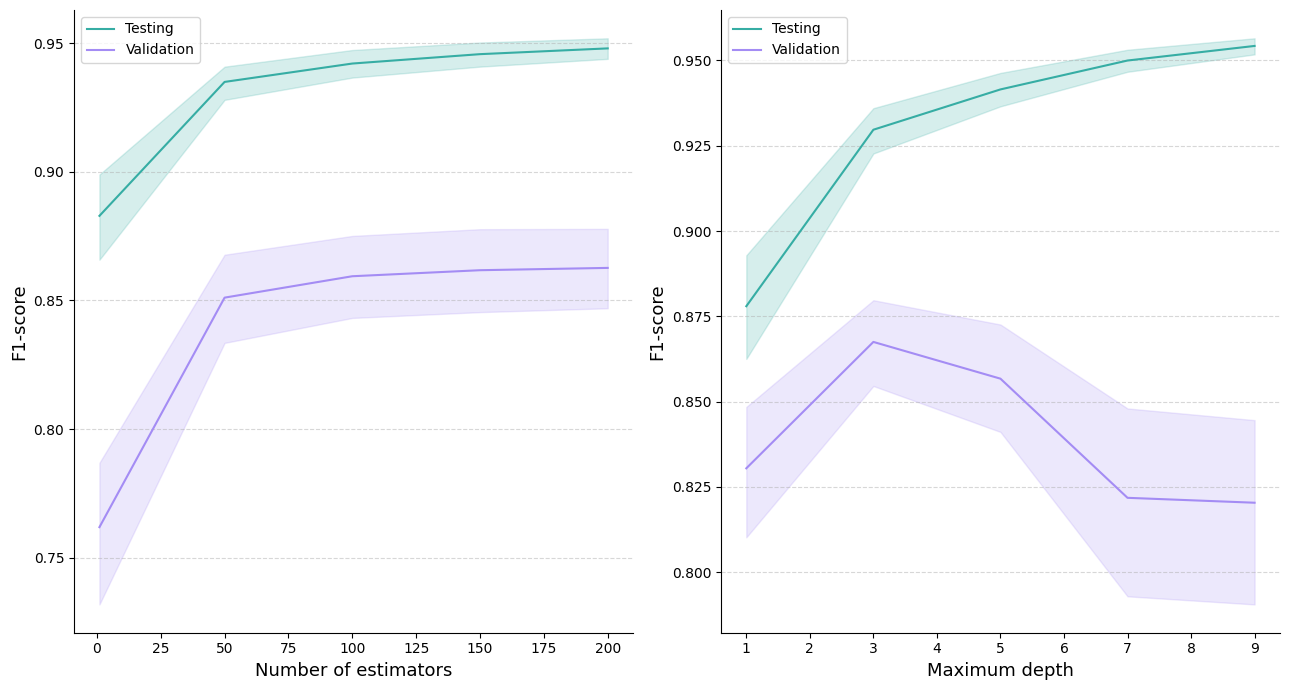

In [90]:
fig, axes = plt.subplots(1,2, figsize=(13, 7)) 

sns.lineplot(x='n_estimators', y='f1-score', data=testing_avg, color=sns.color_palette("husl", 4)[2], ax=axes[0], label="Testing")
sns.lineplot(x='n_estimators', y='f1-score', data=validation_avg, color=sns.color_palette("husl", 4)[3], ax=axes[0], label="Validation")
axes[0].set_xlabel('Number of estimators', fontdict={'size': 13})
axes[0].set_ylabel('F1-score', fontdict={'size': 13})
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

sns.lineplot(x='max_depth', y='f1-score', data=testing_avg, color=sns.color_palette("husl", 4)[2], ax=axes[1], label="Testing")
sns.lineplot(x='max_depth', y='f1-score', data=validation_avg, color=sns.color_palette("husl", 4)[3], ax=axes[1], label="Validation")
axes[1].set_xlabel('Maximum depth', fontdict={'size': 13})
axes[1].set_ylabel('F1-score', fontdict={'size': 13})
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Per class

In [91]:
testing_df_unclassified = testing_df[testing_df["attribute"] == "unclassified"]
validation_df_unclassified = validation_df[validation_df["attribute"] == "unclassified"]

testing_df_mmo = testing_df[testing_df["attribute"] == "man-made objects"]
validation_df_mmo = validation_df[validation_df["attribute"] == "man-made objects"]

testing_df_ground = testing_df[testing_df["attribute"] == "ground"]
validation_df_ground = validation_df[validation_df["attribute"] == "ground"]

testing_df_tree = testing_df[testing_df["attribute"] == "tree trunk/branches"]
validation_df_tree = validation_df[validation_df["attribute"] == "tree trunk/branches"]

testing_df_leaves = testing_df[testing_df["attribute"] == "leaves"]
validation_df_leaves = validation_df[validation_df["attribute"] == "leaves"]

testing_df_lowveg = testing_df[testing_df["attribute"] == "low vegetation"]
validation_df_lowveg = validation_df[validation_df["attribute"] == "low vegetation"]

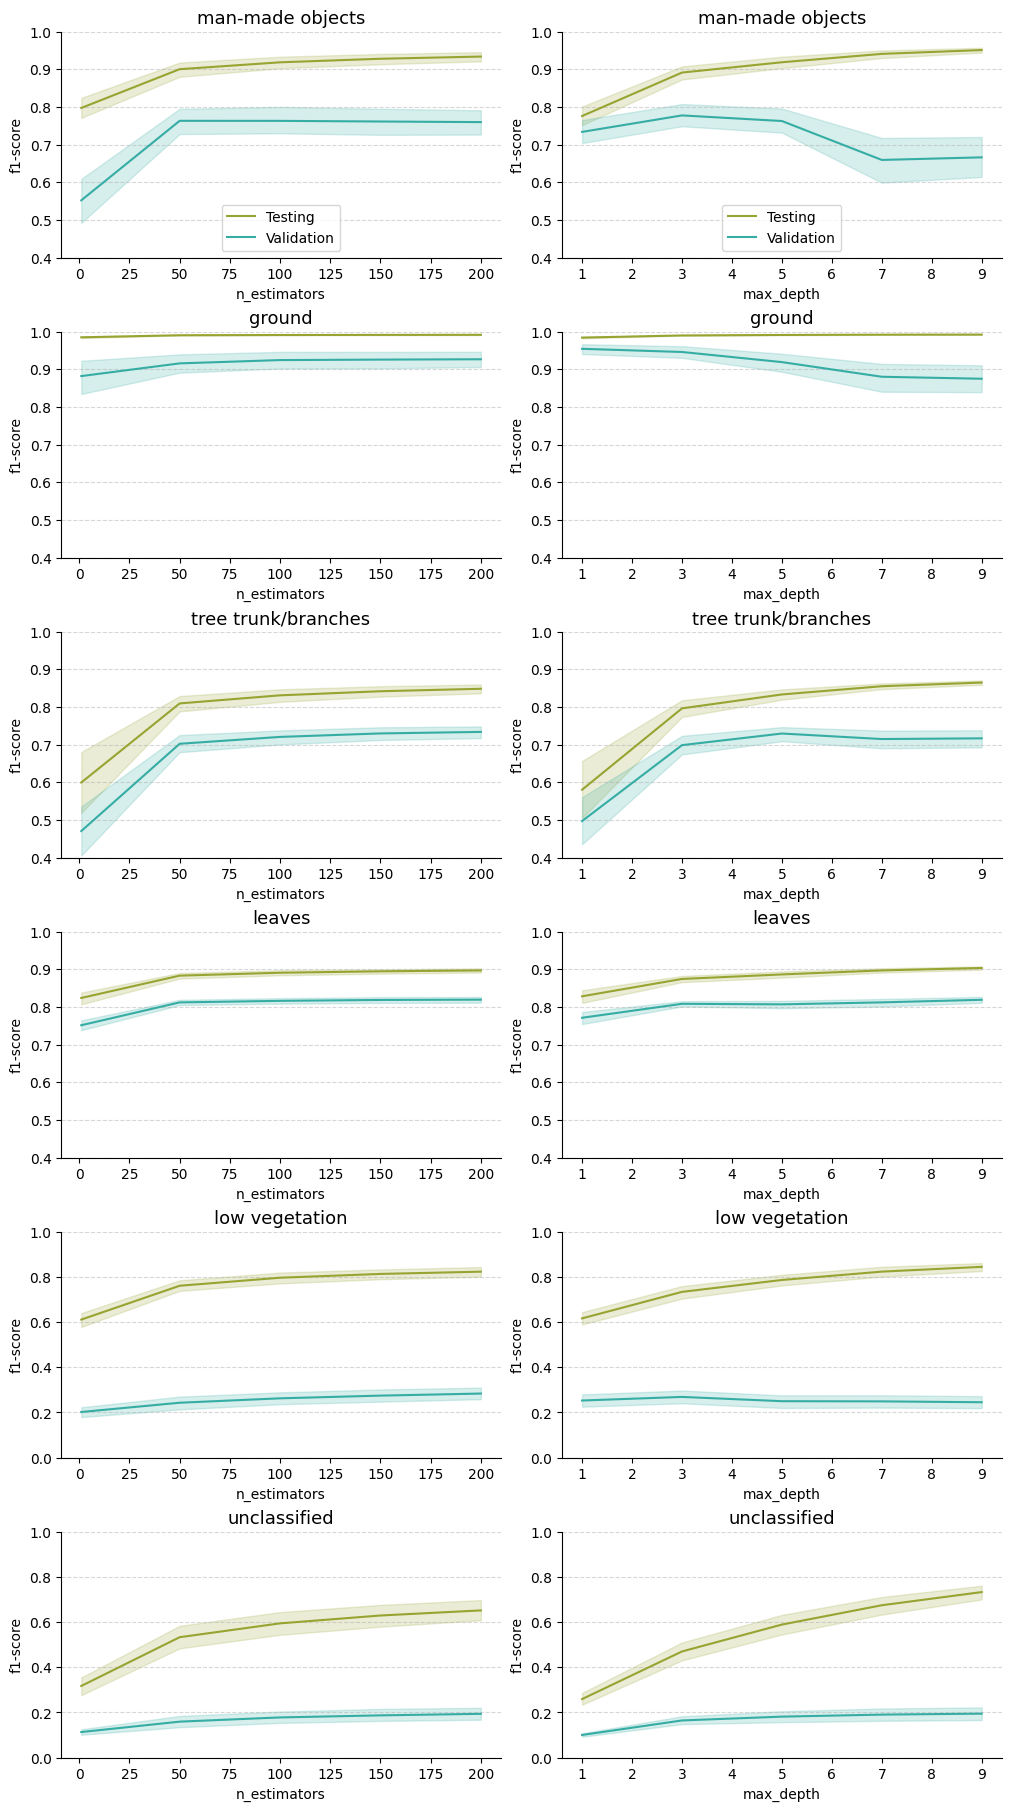

In [93]:
def plot_data(testing_df, validation_df, ax, x_var, y_var, color1, color2, title, legend=True, y_lim=(0.4, 1)):
    if legend:
        sns.lineplot(x=x_var, y=y_var, data=testing_df, color=color1, ax=ax, label="Testing")
        sns.lineplot(x=x_var, y=y_var, data=validation_df, color=color2, ax=ax, label="Validation")
        ax.legend(loc='lower center')
    else:
        sns.lineplot(x=x_var, y=y_var, data=testing_df, color=color1, ax=ax)
        sns.lineplot(x=x_var, y=y_var, data=validation_df, color=color2, ax=ax)
    
    # ax.set_xlabel(' ', fontdict={'size': 13})
    # ax.set_ylabel(' ', fontdict={'size': 13})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_ylim(y_lim)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.set_title(title, fontdict={'size': 13})
    

fig, axes = plt.subplots(6,2, figsize=(10, 18), constrained_layout=True) 

color1 = sns.color_palette("husl", 4)[1]
color2 = sns.color_palette("husl", 4)[2]

plot_data(testing_df_mmo, validation_df_mmo, axes[0,0], 'n_estimators', 'f1-score', color1, color2, testing_df_mmo['attribute'].values[0])
plot_data(testing_df_mmo, validation_df_mmo, axes[0,1], 'max_depth', 'f1-score', color1, color2, testing_df_mmo['attribute'].values[0])
plot_data(testing_df_ground, validation_df_ground, axes[1,0], 'n_estimators', 'f1-score', color1, color2, testing_df_ground['attribute'].values[0], False)
plot_data(testing_df_ground, validation_df_ground, axes[1,1], 'max_depth', 'f1-score', color1, color2, testing_df_ground['attribute'].values[0], False)
plot_data(testing_df_tree, validation_df_tree, axes[2,0], 'n_estimators', 'f1-score', color1, color2, testing_df_tree['attribute'].values[0], False)
plot_data(testing_df_tree, validation_df_tree, axes[2,1], 'max_depth', 'f1-score', color1, color2, testing_df_tree['attribute'].values[0], False)
plot_data(testing_df_leaves, validation_df_leaves, axes[3,0], 'n_estimators', 'f1-score', color1, color2, testing_df_leaves['attribute'].values[0], False)
plot_data(testing_df_leaves, validation_df_leaves, axes[3,1], 'max_depth', 'f1-score', color1, color2, testing_df_leaves['attribute'].values[0], False)
plot_data(testing_df_lowveg, validation_df_lowveg, axes[4,0], 'n_estimators', 'f1-score', color1, color2, testing_df_lowveg['attribute'].values[0], False, (0, 1))
plot_data(testing_df_lowveg, validation_df_lowveg, axes[4,1], 'max_depth', 'f1-score', color1, color2, testing_df_lowveg['attribute'].values[0], False, (0, 1))
plot_data(testing_df_unclassified, validation_df_unclassified, axes[5,0], 'n_estimators', 'f1-score', color1, color2, testing_df_unclassified['attribute'].values[0], False, (0, 1))
plot_data(testing_df_unclassified, validation_df_unclassified, axes[5,1], 'max_depth', 'f1-score', color1, color2, testing_df_unclassified['attribute'].values[0], False, (0, 1))

# Improved classification:

Attributes used:
- Vertical angle, Roughness, Slope, Nx, Ny, Nz, Curvature, Z, Green, Ny

Statistics used: 
- Skewness, 2nd percentile, 75th percentile, 25th percentile, StdDev, 98th percentile

XGBoost parameters used: 
- n_estimators: 100
- max_depth: 3
- learning_rate: 0.3

In [94]:
testing_results_path = root_dir / 'data/final_results/1_best_overall_performance/all_results/testing_cls_results.csv'
validation_results_path = root_dir / 'data/final_results/1_best_overall_performance/all_results/validation_cls_results.csv'

testing_results = pd.read_csv(testing_results_path)
validation_results = pd.read_csv(validation_results_path)

# Rename the first columns
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})
testing_results['mode'] = 'testing'
validation_results = validation_results.rename(columns={'Unnamed: 0': 'attribute'})
validation_results['mode'] = 'validation'

# Remove 'accuracy' and 'macro avg' rows
testing_results = testing_results[testing_results['attribute'] != 'accuracy']
testing_results = testing_results[testing_results['attribute'] != 'macro avg']
validation_results = validation_results[validation_results['attribute'] != 'accuracy']
validation_results = validation_results[validation_results['attribute'] != 'macro avg']

# Merge the two dataframes
all_results = pd.concat([testing_results, validation_results])

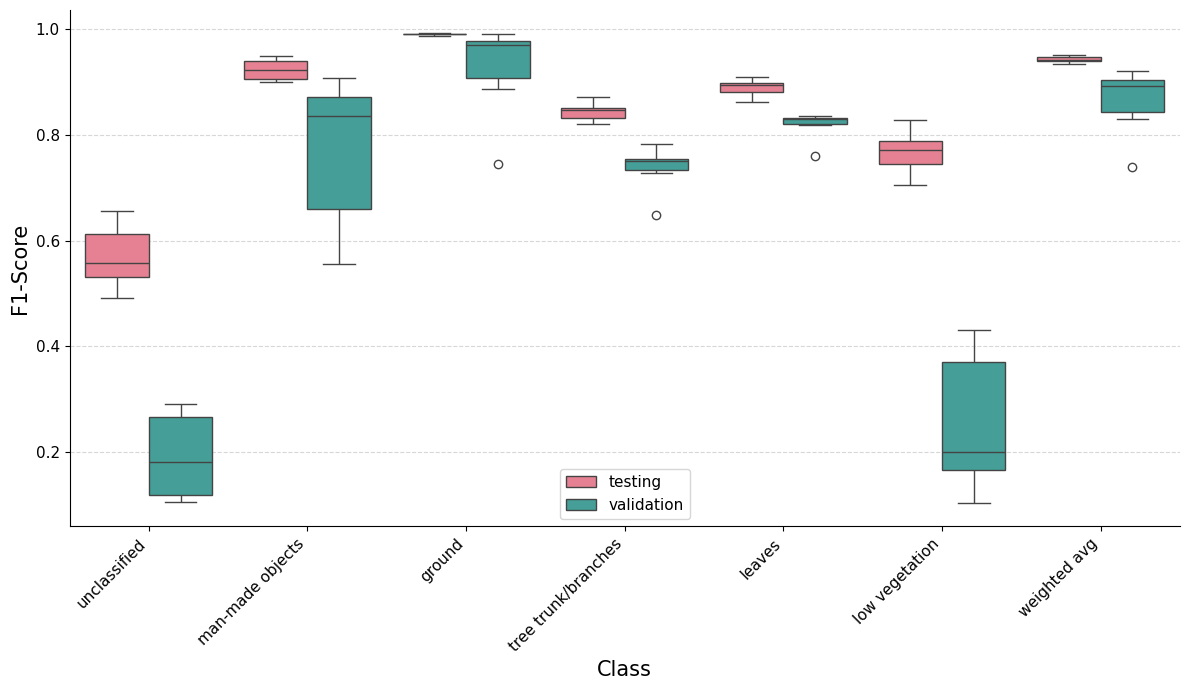

In [95]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

box_plot = sns.boxplot(x='attribute', y='f1-score', data=all_results, hue='mode', palette=sns.color_palette("husl", 2), ax=ax1)

# Highlight 'weighted avg' with light grey color
for i, artist in enumerate(box_plot.artists):
    print(i, artist.get_facecolor())
    print(artist)
    
    # This artist contains rectangle for boxplot
    if box_plot.get_xticklabels()[i].get_text() == 'weighted avg':
        print('weighted avg')
        artist.set_facecolor('lightgrey')

ax1.set_xlabel('Class', fontdict={'size': 15})
ax1.set_ylabel('F1-Score', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Ajust legend
ax1.legend(loc='lower center', fontsize=11, title='')

plt.tight_layout()
plt.show()

## Confusion matrices

### Training

In [98]:
cnf_mat_testing_results_path = root_dir / 'data/final_results/1_best_overall_performance/confusion_matrices_testing'

In [99]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_testing_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_testing_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [100]:
cnf_mat_testing_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.7152,0.1999,0.0300,0.0123,0.0107,0.0318
man-made objects,0.0324,0.9035,0.0352,0.0070,0.0056,0.0163
ground,0.0001,0.0009,0.9971,0.0001,0.0002,0.0016
tree trunk/branches,0.0142,0.0203,0.0139,0.8564,0.0883,0.0069
leaves,0.0195,0.0026,0.0127,0.1066,0.8546,0.0041
low vegetation,0.0142,0.0211,0.0710,0.0058,0.0003,0.8876


### Validation

In [102]:
cnf_mat_validation_results_path = root_dir / 'data/final_results/1_best_overall_performance/confusion_matrices_validation'

In [103]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_validation_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_validation_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [104]:
cnf_mat_validation_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.6751,0.1385,0.0607,0.0481,0.0168,0.0608
man-made objects,0.0492,0.8525,0.0099,0.0837,0.0015,0.0032
ground,0.0200,0.0329,0.8997,0.0004,0.0003,0.0466
tree trunk/branches,0.0337,0.1250,0.0194,0.7444,0.0644,0.0132
leaves,0.0514,0.0038,0.0083,0.1804,0.7387,0.0174
low vegetation,0.2094,0.0285,0.1275,0.0012,0.0012,0.6322


# Benchmarking 

**Scanline approach versus 3D approach**